# Market Basket Analysis on Online Retail Data

>Ming Zhao <br>

## Outline

- Data Preprocessing
- Association Rule Mining
    - Support
    - Confidence
    - Lift
    - Apriori Algorithm

### Report

#### Procedure

First, I cleaned the data by excluding observations with negative quantities. Second, I converted the data into a different format in which merchandise codes are columns and transaction numbers are indices. There are 3941 unique items and 20728 transactions. The new data is a boolean type with 1 indicating an item is bought in a transaction and 0 otherwise. Third, I identified 30 most frequently purchased items; `85123A`, `85099B`, and `22423` appear in more than 2000 transactions and all the rest of frequent items appear in at least 1000 transactions. 

To explore the association between two products, I then generated a pairwise frequency matrix by using dot product of the 30 identified items. To further explore association rules of pairwise products, I applied **apriori algorithm** and utilized three core measures, **support**, **confidence**, and **lift**. I plotted the pairwise matrices on the three measures separately. I also made a colored scatter plot to show the relationship among support, confidence, and lift. Finally, I created a network graph to show the association rules between two products. The displayed assocition rules are conditional on $support >= 1\%$ and $confidence >=30\%$, and this gives all values of $lift >3$.

#### Summary

From the generated associaltion rules, `20725`, `20727`, `20728`, `22382`, `22383`, `22384`, `23209`, `85099B` are most likely to be purchased with other items, by considering their frequencies either as antecedents or consequents in the association rules. 

- `22384` is the most frequent antecedents. For example, when buying `22384`, customers are very likely to buy `20725`, `20727`, `20728`, `22382`, `22383`, `23209`, or `85099B`. 

- `85099B` and `22383` are the most frequent consequents in which they have high likelihood of being paired when buying other products. For example, when buying `20725` or `22384`, customers are very likely to also buy `85099B` or `22383`.

`85099B & 22386`, `85099B & 21931`, `85099B & 22411`, `20725 & 22383`, and `20725 & 20727` are the products that are the most likely to be bought together, with frequency of 825, 724, 680, 655, and 641, respectively. In other words, the 5 pairs have the highest support values ranging from 3.98% to 3.09%. 

- Among the 5 pairs or the 10 association rules, `22386 => 85099B`, `21931 => 85099B`, `22411 => 85099B`, `22383 => 20725`, `20727 => 20725` have the highest confidence values of 0.68, 0.61, 0.58, 0.51, 0.50, respectively. For example, if a customer has decided to buy `22386`, then the probability of buying `85099B` is 0.68.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx

## Data Cleaning

In [2]:
retail = pd.read_csv("Online_Retail.csv")

In [3]:
retail.head()

,Unnamed: 0,TransactionNo,MerchandiseCode,Quan,TransactionDate,ItemPrice,UserID
0,0,29138841,85123A,8,2022-09-01,2.76,208163.0
1,1,29138841,71053,8,2022-09-01,2.12,208163.0
2,2,29138841,84406B,8,2022-09-01,5.12,208163.0
3,3,29138841,84029G,8,2022-09-01,4.33,208163.0
4,4,29138841,84029E,8,2022-09-01,3.39,208163.0


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       541909 non-null  int64  
 1   TransactionNo    541909 non-null  object 
 2   MerchandiseCode  541909 non-null  object 
 3   Quan             541909 non-null  int64  
 4   TransactionDate  541909 non-null  object 
 5   ItemPrice        541909 non-null  float64
 6   UserID           406829 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 28.9+ MB


In [5]:
retail["Quan"].describe()

count    541909.000000
mean          9.551611
std         218.080464
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quan, dtype: float64

In [6]:
# Remove observations with non-positive quantities

retail = retail[(retail["Quan"]>0)]

In [7]:
retail.shape

(531285, 7)

In [8]:
retail["Quan"].describe()

count    531285.000000
mean         10.654611
std         156.829343
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quan, dtype: float64

In [9]:
retail["MerchandiseCode"].nunique() # 3941 items

3941

In [10]:
retail["TransactionNo"].nunique() # 20728 transactions

20728

## Data Preprocessing

In [11]:
# Convert data into the following format

'''
e.g.
                  item1 item2 item3 item4
transaction  1      0     1     1     1
             2      1     0     1     0 
             3      1     0     0     1
             4      0     1     0     1
             5      1     1     1     0b
'''

all_items = pd.pivot_table(data=retail, index="TransactionNo", columns="MerchandiseCode",
                           values="Quan", aggfunc="sum", fill_value=0)

In [12]:
all_items.head()

MerchandiseCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
TransactionNo,,,,,,,,,,,,,,,,,,,,,
22345123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22753781,48,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
229376172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28126381,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
291388311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
all_items.shape # consistent with unique transactions and items

(20728, 3941)

In [14]:
# Recode positive quantities into 1 
## (the specific quantities are meaningless, instead, whether the item has been taken is considered)

all_items_1_0 = np.where(all_items[all_items.columns]>0, 1, 0)

In [15]:
all_items = pd.DataFrame(all_items_1_0, index=all_items.index, columns=all_items.columns)
all_items.head()

MerchandiseCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
TransactionNo,,,,,,,,,,,,,,,,,,,,,
22345123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22753781,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
229376172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28126381,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
291388311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
plot_items30 = pd.DataFrame(all_items.sum().sort_values(ascending=False).head(30))
plot_items30.head()

,0
MerchandiseCode,
85123A,2203
85099B,2092
22423,1989
47566,1686
20725,1565


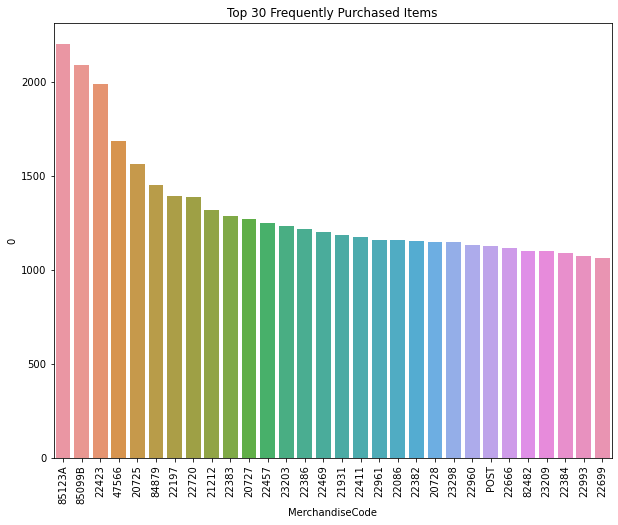

In [17]:
# Plot the top 30 frequent items

plt.figure(figsize=(10, 8))
plt.title('Top 30 Frequently Purchased Items')
plt.ylabel('Count')
plt.xlabel('Merchandise Code')
plt.xticks(rotation=90)
sns.barplot(x=plot_items30.index, y=plot_items30[0])
plt.show()

In [18]:
# Store the top 30 frequent items

items30 = plot_items30.index.tolist()

In [19]:
# Keep the top 30 items only

top_items = all_items[items30] # for Apriori Algorithm use later

In [20]:
top_items.shape

(20728, 30)

In [21]:
# Create a pairwise frequency matrix

'''
e.g.
                  item1 item2 item3 item4
transaction  1      0     1     1     1
             2      1     0     1     0 
             3      1     0     0     1
             4      0     1     0     1
             5      1     1     1     0
=>

       item1 item2 item3 item4
item1   NA     1     2     1
item2          NA    2     2
item3                NA    1
item4                      NA

'''

pair_matrix = top_items.T.dot(top_items) # dot product

In [22]:
# Fill lower triangle with nan

temp_matrix = np.matrix(pair_matrix.astype(float))
temp_matrix[np.tril_indices_from(temp_matrix)] = np.nan 

pair_freq = pd.DataFrame(temp_matrix, index=pair_matrix.index, columns=pair_matrix.columns)

In [23]:
pair_freq.head()

MerchandiseCode,85123A,85099B,22423,47566,20725,84879,22197,22720,21212,22383,...,20728,23298,22960,POST,22666,82482,23209,22384,22993,22699
MerchandiseCode,,,,,,,,,,,,,,,,,,,,,
85123A,NaN,401.0,351.0,390.0,330.0,324.0,307.0,299.0,266.0,273.0,...,236.0,217.0,245.0,17.0,273.0,370.0,203.0,252.0,244.0,228.0
85099B,NaN,NaN,286.0,328.0,579.0,165.0,400.0,305.0,330.0,405.0,...,325.0,223.0,287.0,86.0,288.0,285.0,313.0,363.0,266.0,256.0
22423,NaN,NaN,NaN,395.0,277.0,270.0,267.0,312.0,358.0,231.0,...,221.0,194.0,287.0,156.0,297.0,173.0,152.0,178.0,227.0,525.0
47566,NaN,NaN,NaN,NaN,319.0,234.0,242.0,247.0,303.0,284.0,...,225.0,483.0,214.0,35.0,236.0,196.0,171.0,209.0,230.0,216.0
20725,NaN,NaN,NaN,NaN,NaN,165.0,300.0,217.0,346.0,655.0,...,555.0,219.0,210.0,88.0,241.0,176.0,462.0,606.0,201.0,192.0


In [24]:
# Find the most 3 frequent pairwise items

print(pair_freq.max().nlargest(5))
print(pair_freq[pair_freq["22386"]==825].index)
print(pair_freq[pair_freq["21931"]==724].index)
print(pair_freq[pair_freq["22411"]==680].index)
print(pair_freq[pair_freq["22383"]==655].index)
print(pair_freq[pair_freq["20727"]==641].index)

MerchandiseCode
22386    825.0
21931    724.0
22411    680.0
22383    655.0
20727    641.0
dtype: float64
Index(['85099B'], dtype='object', name='MerchandiseCode')
Index(['85099B'], dtype='object', name='MerchandiseCode')
Index(['85099B'], dtype='object', name='MerchandiseCode')
Index(['20725'], dtype='object', name='MerchandiseCode')
Index(['20725'], dtype='object', name='MerchandiseCode')


In [25]:
print(np.nanmax(temp_matrix))
print(np.nanmin(temp_matrix))
print(np.nanmean(temp_matrix))

825.0
6.0
217.34942528735633


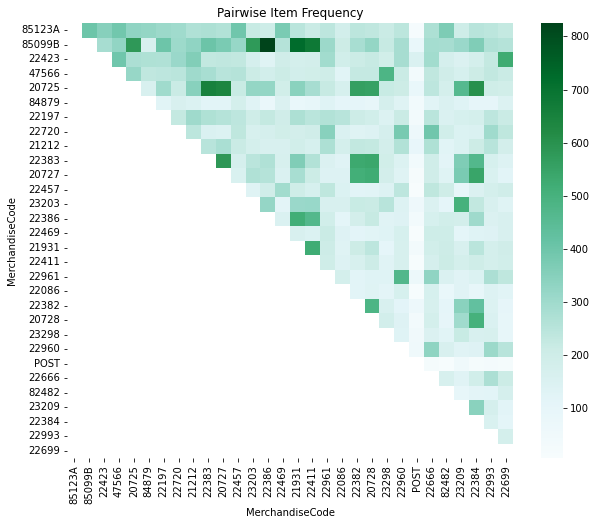

In [26]:
# Plot the pairwise frequency matrix

plt.figure(figsize=(10, 8))
plt.title('Pairwise Item Frequency')
sns.heatmap(data = pair_freq, annot = False, vmin = 6, vmax = 825, cmap = 'BuGn')
plt.show()

## Association Rule Mining

"Association Rule Mining is a rule-based machine learning method that helps to uncover meaningful correlations between different products according to their co-occurrence in a data set" ([ref1](https://towardsdatascience.com/data-mining-market-basket-analysis-with-apriori-algorithm-970ff256a92c)).

### Support
(the frequently bought items or the combination of items bought frequently)

$$support = P(A \& B) = \frac{number \space of \space transactions \space containing \space A \space and \space B}{total \space number \space of \space transactions}$$

### Confidence

(the probability of event A happening given that event B has already happened)

$$confidence\space(A \Rightarrow B) = P(B \mid A) = \frac{supp\space(A \& B)}{supp\space(A)} = \frac{number \space of \space transactions \space containing \space A \space and \space B}{number \space of \space transactions \space containing \space A}$$

### Lift

(how likely an item is purchased when another item is purchased, while controlling for how popular both items are)

$$lift\space(A \Rightarrow B) = \frac{supp\space(A \& B)}{supp\space(A) \space \times \space supp\space(B)}$$

- Lift (A => B) = 1 means that there is no correlation within the itemset.
- Lift (A => B) > 1 means that there is a positive correlation within the itemset, i.e., A and B are more likely to be bought together.
- Lift (A => B) < 1 means that there is a negative correlation within the itemset, i.e., A and B are unlikely to be bought together.


### Apriori Algorithm

"The Apriori Algorithm is one of the most popular algorithms used in association rule learning over relational databases. It identifies the items in a data set and further extends them to larger and larger item sets" ([ref1](https://towardsdatascience.com/data-mining-market-basket-analysis-with-apriori-algorithm-970ff256a92c)).

- Property

"**All subsets of a frequent itemset must be frequent. If an itemset is infrequent, all its supersets will be infrequent**" ([ref2](https://www.geeksforgeeks.org/apriori-algorithm/)).


- Iterations:

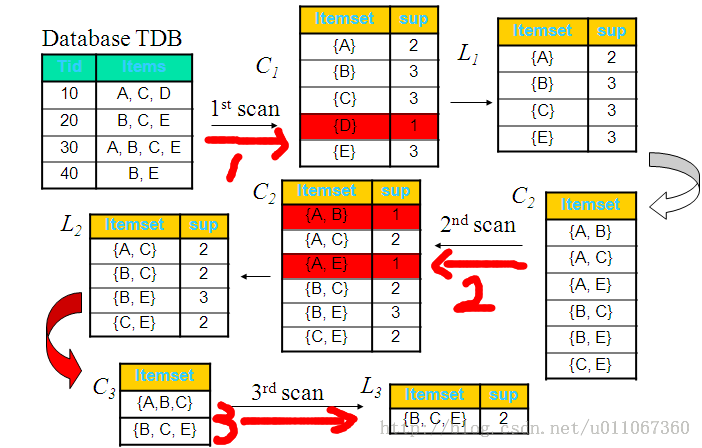
[ref3](https://bainingchao.github.io/2018/09/27/一步步教你轻松学关联规则Apriori算法/)

*Assume 1) **the minimum support is 2** and 2) **the minimum confidence is 60%**.*


e.g.1

$$confidence\space(\{B, E\} \Rightarrow \{C\}) = P(\{C\} \mid \{B, E\}) = \frac{supp\space(\{B, E\} \& \{C\})}{supp\space(\{B, E\})} = \frac{\frac{n_{\{B, C, E\}}}{N}}{\frac{n_{\{B, E\}}}{N}} = \frac{2}{3} > 60\% $$

Hence, $\{B, E\} \Rightarrow \{C\}$ is selected

$$lift\space(\{B, E\} \Rightarrow \{C\}) = \frac{supp\space(\{B, E\} \& \{C\})}{supp\space(\{B, E\}) \space \times \space supp\space(\{C\})} = \frac{\frac{n_{\{B, C, E\}}}{N}}{\frac{n_{\{B, E\}}}{N} \times \frac{n_{\{C\}}}{N}} = \frac{2/4}{3/4 \times 3/4} = \frac{8}{9} < 1$$

e.g.2

$$confidence\space(\{B\} \Rightarrow \{C, E\}) = P(\{C, E\} \mid \{B\}) = \frac{supp\space(\{B\} \& \{C, E\})}{supp\space(\{B\})} = \frac{\frac{n_{\{B, C, E\}}}{N}}{\frac{n_{\{B\}}}{N}} = \frac{2}{3} > 60\% $$

Hence, $\{B\} \Rightarrow \{C, E\}$ is selected

$$lift\space(\{B\} \Rightarrow \{C, E\}) = \frac{supp\space(\{B\} \& \{C, E\})}{supp\space(\{B\}) \space \times \space supp\space(\{C, E\})} = \frac{\frac{n_{\{B, C, E\}}}{N}}{\frac{n_{\{B\}}}{N} \times \frac{n_{\{C, E\}}}{N}} = \frac{2/4}{3/4 \times 2/4} = \frac{4}{3} > 1$$


In [27]:
# Convert data to the boolean type

top_items = top_items.astype('bool')
top_items.head()

MerchandiseCode,85123A,85099B,22423,47566,20725,84879,22197,22720,21212,22383,...,20728,23298,22960,POST,22666,82482,23209,22384,22993,22699
TransactionNo,,,,,,,,,,,,,,,,,,,,,
22345123,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
22753781,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
229376172,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28126381,True,True,True,False,True,False,True,False,True,True,...,False,False,True,False,True,False,False,True,False,True
291388311,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [28]:
# Generate frequent itemsets that have a support value of at least 0.1%

frequent_itemsets = apriori(top_items, min_support=0.001, use_colnames=True, max_len=2) # 20728*0.001 = 20.728

In [29]:
frequent_itemsets.tail()

,support,itemsets
453,0.008443,"(22993, 23209)"
454,0.005934,"(22699, 23209)"
455,0.007574,"(22993, 22384)"
456,0.005403,"(22699, 22384)"
457,0.008491,"(22699, 22993)"


In [30]:
# Generate the rules with corresponding support, confidence, and lift

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [31]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(85123A),(85099B),0.106281,0.100926,0.019346,0.182025,1.803539,0.008619,1.099145,0.498518
1,(85099B),(85123A),0.100926,0.106281,0.019346,0.191683,1.803539,0.008619,1.105653,0.495549
2,(85123A),(22423),0.106281,0.095957,0.016934,0.159328,1.660410,0.006735,1.075381,0.445038
3,(22423),(85123A),0.095957,0.106281,0.016934,0.176471,1.660410,0.006735,1.085230,0.439956
4,(85123A),(47566),0.106281,0.081339,0.018815,0.177031,2.176456,0.010170,1.116277,0.604818


In [32]:
rules.shape

(820, 10)

In [33]:
# Convert date into a pairwise matrix on support, confidence, and lift

rules_copy = rules.copy()

rules_copy["antecedents"] = rules_copy["antecedents"].astype(str)
rules_copy["consequents"] = rules_copy["consequents"].astype(str)

rules_copy['antecedents'] = rules_copy['antecedents'].str.removeprefix("frozenset({'")
rules_copy['antecedents'] = rules_copy['antecedents'].str.removesuffix("'})")

rules_copy['consequents'] = rules_copy['consequents'].str.removeprefix("frozenset({'")
rules_copy['consequents'] = rules_copy['consequents'].str.removesuffix("'})")

support = pd.pivot_table(data=rules_copy, index="antecedents", columns="consequents",
                           values="support", fill_value=np.nan)
confidence = pd.pivot_table(data=rules_copy, index="antecedents", columns="consequents",
                           values="confidence", fill_value=np.nan)
lift = pd.pivot_table(data=rules_copy, index="antecedents", columns="consequents",
                           values="lift", fill_value=np.nan)

In [34]:
pair_support = support[items30].reindex(items30)
pair_confidence = confidence[items30].reindex(items30)
pair_lift = lift[items30].reindex(items30)

In [35]:
rules_copy[["support", "confidence", "lift"]].describe()

,support,confidence,lift
count,820.000000,820.000000,820.000000
mean,0.011021,0.175776,2.798464
std,0.005505,0.087635,1.369208
min,0.003184,0.056230,1.031448
25%,0.007430,0.118443,1.984004
50%,0.009504,0.152551,2.422528
75%,0.012833,0.199470,3.122825
max,0.039801,0.677340,8.301122


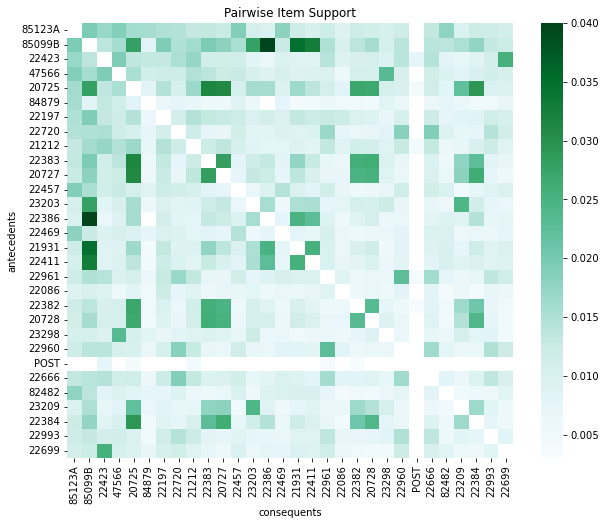

In [36]:
# Plot the pairwise support matrix

plt.figure(figsize=(10, 8))
plt.title('Pairwise Item Support')
sns.heatmap(data = pair_support, annot = False, vmin = 0.003, vmax = 0.04, cmap = 'BuGn')
plt.show()

In [37]:
# Display top5 support

rules_copy.sort_values(by=["support"], ascending=False)[["antecedents","consequents","support","confidence"]].head(10)

,antecedents,consequents,support,confidence
79,85099B,22386,0.039801,0.394359
78,22386,85099B,0.039801,0.677340
82,21931,85099B,0.034929,0.611486
83,85099B,21931,0.034929,0.346080
84,22411,85099B,0.032806,0.578723
85,85099B,22411,0.032806,0.325048
222,20725,22383,0.031600,0.418530
223,22383,20725,0.031600,0.509728
224,20725,20727,0.030924,0.409585
225,20727,20725,0.030924,0.503535


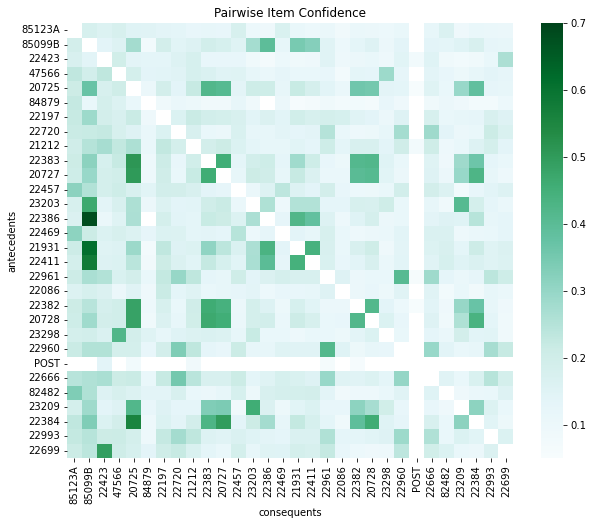

In [38]:
# Plot the pairwise confidence matrix

plt.figure(figsize=(10, 8))
plt.title('Pairwise Item Confidence')
sns.heatmap(data = pair_confidence, annot = False, vmin = 0.05, vmax = 0.7, cmap = 'BuGn')
plt.show()

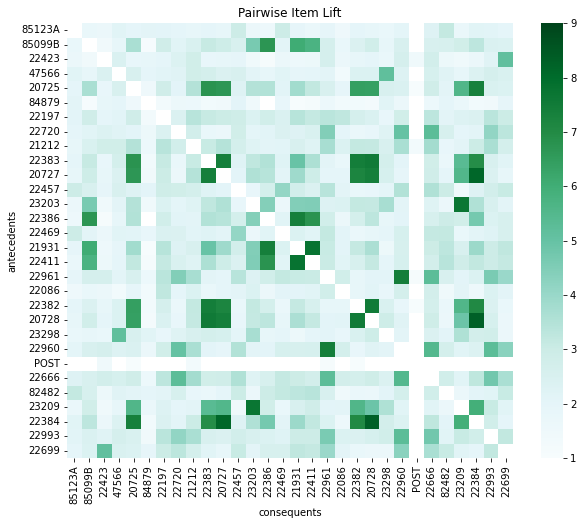

In [39]:
# Plot the pairwise lift matrix

plt.figure(figsize=(10, 8))
plt.title('Pairwise Item Lift')
sns.heatmap(data = pair_lift, annot = False, vmin = 1, vmax = 9, cmap = 'BuGn')
plt.show()

In [40]:
# Create conditional rules on support and confidence

plot_rules = rules_copy[(rules_copy["support"]>=0.01) & (rules_copy["confidence"]>=0.3)]
plot_rules.shape

(64, 10)

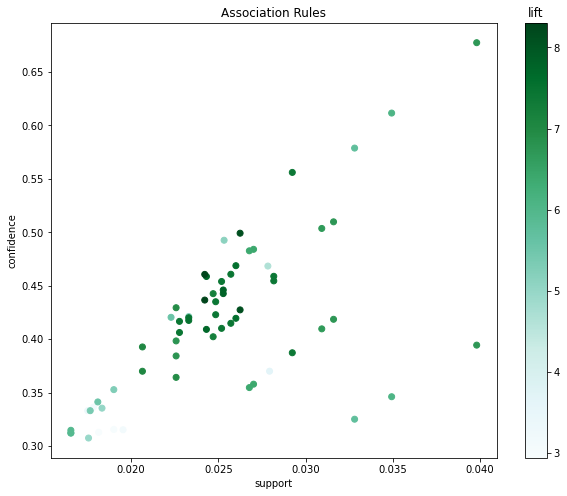

In [41]:
# Plot association rules

plt.figure(figsize=(10, 8))
plt.title('Association Rules')
plt.scatter(plot_rules["support"], plot_rules["confidence"], c=plot_rules["lift"], cmap='BuGn')
plt.xlabel("support")
plt.ylabel("confidence")
plt.colorbar().ax.set_title("lift")
plt.show()

In [42]:
# Generate data for network plotting

network_rules = nx.from_pandas_edgelist(plot_rules, source="antecedents", 
                                        target="consequents",
                                        edge_attr="support")

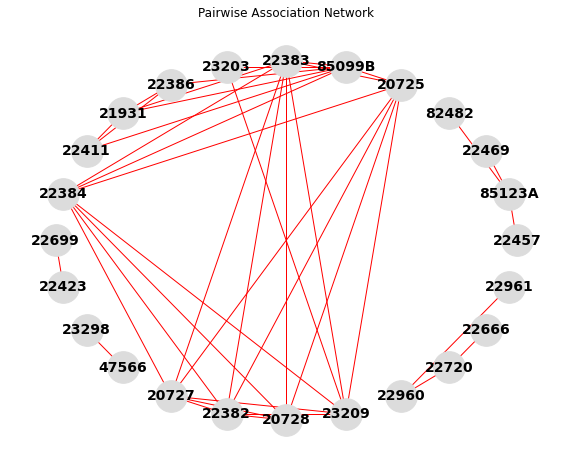

In [43]:
# Plot network
## (reference: https://medium.com/@chyun55555/market-basket-analysis-with-association-rules-and-network-graphiong-with-python-96319585fd27)

plt.figure(figsize=(10, 8))
plt.title('Pairwise Association Network')
nx.draw_circular(network_rules, with_labels=True, node_size=1000, node_color='Gainsboro', 
                 edge_color="red", font_size=14, font_weight='bold')
plt.show()

In [44]:
print(plot_rules["antecedents"].nunique())
print(plot_rules["antecedents"].value_counts().head(10))

20
22384     7
20725     6
22383     6
23209     6
22382     5
20728     5
20727     5
21931     4
22386     3
85099B    3
Name: antecedents, dtype: int64


In [45]:
print(plot_rules["consequents"].nunique())
print(plot_rules["consequents"].value_counts().head(10))

18
22383     7
85099B    7
20727     6
22384     6
22382     6
20725     6
20728     5
85123A    3
22411     3
21931     3
Name: consequents, dtype: int64


In [46]:
# Display confidence

pd.set_option('display.max_rows', None)
plot_rules.sort_values(by=["confidence"], ascending=False)[["antecedents","consequents","confidence","support","lift"]].sort_values(by=["consequents"], ascending=False)

,antecedents,consequents,confidence,support,lift
27,22469,85123A,0.312812,0.018140,2.943244
20,22457,85123A,0.315452,0.019008,2.968087
47,82482,85123A,0.336364,0.017850,3.164841
78,22386,85099B,0.677340,0.039801,6.711234
84,22411,85099B,0.578723,0.032806,5.734120
70,22383,85099B,0.315175,0.019539,3.122825
104,22384,85099B,0.333028,0.017513,3.299711
60,20725,85099B,0.369968,0.027933,3.665726
76,23203,85099B,0.468344,0.027837,4.640458
82,21931,85099B,0.611486,0.034929,6.058744
